In [75]:
# Import necessary libraries
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import re
from typing import List, Tuple

In [76]:
# Preprocessing class for handling text data
class TextPreprocessor:
    def __init__(self, max_len: int = 100):
        self.max_len = max_len
        self.vocab = {'<PAD>': 0, '<UNK>': 1}  # Initial vocabulary with padding and unknown tokens
        self.vocab_size = 2
    
    def tokenize(self, text: str) -> List[str]:
        """Tokenize HTML text into meaningful components."""
        # Separate HTML tags and attributes
        text = re.sub(r'([<>/="])', r' \1 ', text)
        # Remove extra whitespace
        text = ' '.join(text.split())
        return text.lower().split()
    
    def build_vocab(self, texts: List[str], min_freq: int = 2):
        """Build vocabulary with common tokens"""
        counter = Counter()
        for text in texts:
            tokens = self.tokenize(text)
            counter.update(tokens)
        
        # Add words meeting the minimum frequency threshold
        for word, freq in counter.items():
            if freq >= min_freq and word not in self.vocab:
                self.vocab[word] = self.vocab_size
                self.vocab_size += 1
    
    def encode_text(self, text: str) -> List[int]:
        """Convert text to integer sequence"""
        tokens = self.tokenize(text)
        # Truncate or pad to specified length
        if len(tokens) > self.max_len:
            tokens = tokens[:self.max_len]
        else:
            tokens.extend(['<PAD>'] * (self.max_len - len(tokens)))
        
        return [self.vocab.get(token, self.vocab['<UNK>']) for token in tokens]


In [77]:

# Custom Dataset class for XSS data
class XSSDataset(Dataset):
    def __init__(self, texts: List[str], labels: List[int], preprocessor: TextPreprocessor):
        self.preprocessor = preprocessor
        self.encodings = [self.preprocessor.encode_text(text) for text in texts]
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[torch.Tensor, torch.Tensor]:
        return (torch.tensor(self.encodings[idx], dtype=torch.long),
                torch.tensor(self.labels[idx], dtype=torch.float))

In [78]:
# LSTM model class for XSS detection
class XSSDetectorLSTM(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int = 50, 
                 hidden_dim: int = 64, num_layers: int = 2, dropout: float = 0.2):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )
        self.fc1 = nn.Linear(hidden_dim * 2, 32)
        self.fc2 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, _) = self.lstm(embedded)
        
        # Use the last time step's hidden state
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        out = self.dropout(hidden)
        out = torch.relu(self.fc1(out))
        out = torch.sigmoid(self.fc2(out))
        return out


In [79]:
# Detector class to handle training and prediction
class XSSDetector:
    def __init__(self, max_len: int = 100, device: str = None):
        if device is None:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = torch.device(device)
        
        self.max_len = max_len
        self.preprocessor = TextPreprocessor(max_len)
        self.model = None
        self.training_losses = []
        self.validation_losses = []
    
    def train(self, texts: List[str], labels: List[int], 
              epochs: int = 10, batch_size: int = 32, learning_rate: float = 0.001,
              val_split: float = 0.1):
        
        # Build vocabulary and create dataset as before...
        self.preprocessor.build_vocab(texts)
        dataset = XSSDataset(texts, labels, self.preprocessor)
        
        # Split dataset and create loaders...
        val_size = int(len(dataset) * val_split)
        train_size = len(dataset) - val_size
        train_dataset, val_dataset = torch.utils.data.random_split(
            dataset, [train_size, val_size]
        )
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        
        # Initialize model...
        self.model = XSSDetectorLSTM(
            vocab_size=self.preprocessor.vocab_size,
            embedding_dim=50
        ).to(self.device)
        
        optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        criterion = nn.BCELoss()
        
        # Lists to store losses
        self.training_losses = []
        self.validation_losses = []
        
        # Training loop
        for epoch in range(epochs):
            self.model.train()
            total_loss = 0
            correct = 0
            total = 0
            
            for batch_sequences, batch_labels in train_loader:
                batch_sequences = batch_sequences.to(self.device)
                batch_labels = batch_labels.to(self.device)
                
                optimizer.zero_grad()
                outputs = self.model(batch_sequences).squeeze()
                loss = criterion(outputs, batch_labels)
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
                
                predictions = (outputs >= 0.5).float()
                correct += (predictions == batch_labels).sum().item()
                total += len(batch_labels)
            
            # Calculate average training loss for this epoch
            avg_train_loss = total_loss / len(train_loader)
            self.training_losses.append(avg_train_loss)
            
            # Validation
            self.model.eval()
            val_loss = 0
            val_correct = 0
            val_total = 0
            
            with torch.no_grad():
                for batch_sequences, batch_labels in val_loader:
                    batch_sequences = batch_sequences.to(self.device)
                    batch_labels = batch_labels.to(self.device)
                    
                    outputs = self.model(batch_sequences).squeeze()
                    val_loss += criterion(outputs, batch_labels).item()
                    
                    predictions = (outputs >= 0.5).float()
                    val_correct += (predictions == batch_labels).sum().item()
                    val_total += len(batch_labels)
            
            # Calculate average validation loss for this epoch
            avg_val_loss = val_loss / len(val_loader)
            self.validation_losses.append(avg_val_loss)
            
            print(f'Epoch {epoch+1}/{epochs}:')
            print(f'Training Loss: {avg_train_loss:.4f}')
            print(f'Training Accuracy: {100*correct/total:.2f}%')
            print(f'Validation Loss: {avg_val_loss:.4f}')
            print(f'Validation Accuracy: {100*val_correct/val_total:.2f}%\n')




In [80]:
# Function to demonstrate the detector with example inputs
def demo_detector():
    # Load dataset
    data = pd.read_csv('dataset/XSS_dataset.csv')
    texts = data['Sentence'].tolist()
    labels = data['Label'].tolist()
    
    # Initialize detector
    detector = XSSDetector(max_len=100)
    
    # Train model
    detector.train(
        texts=texts,
        labels=labels,
        epochs=5,
        batch_size=32,
        learning_rate=0.001
    )
    
    # Plot training and validation losses
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(detector.training_losses) + 1), detector.training_losses, label='Training Loss')
    plt.plot(range(1, len(detector.validation_losses) + 1), detector.validation_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Test with some example cases
    test_cases = [
        "<script>alert(1)</script>",
        "<img src='x' onerror='alert(1)'>",
        "<a href='/wiki/Portal:Philosophy'>Philosophy portal</a>",
        "<span class='reference-text'>Normal text</span>"
    ]
    
    print("\nTesting some examples:")
    for test_input in test_cases:
        risk_score = detector.predict(test_input)
        print(f"Risk score for '{test_input}': {risk_score:.3f}")

Epoch 1/5:
Training Loss: 0.0873
Training Accuracy: 96.57%
Validation Loss: 0.0182
Validation Accuracy: 99.49%

Epoch 2/5:
Training Loss: 0.0184
Training Accuracy: 99.36%
Validation Loss: 0.0114
Validation Accuracy: 99.56%

Epoch 3/5:
Training Loss: 0.0131
Training Accuracy: 99.59%
Validation Loss: 0.0072
Validation Accuracy: 99.63%

Epoch 4/5:
Training Loss: 0.0071
Training Accuracy: 99.75%
Validation Loss: 0.0081
Validation Accuracy: 99.71%

Epoch 5/5:
Training Loss: 0.0054
Training Accuracy: 99.84%
Validation Loss: 0.0093
Validation Accuracy: 99.71%



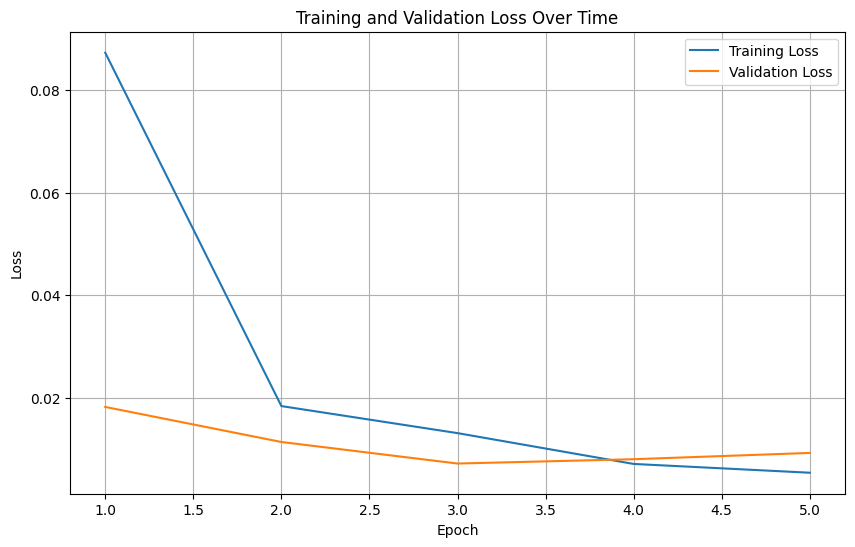


Testing some examples:


AttributeError: 'XSSDetector' object has no attribute 'predict'

In [81]:
# Run demonstration
if __name__ == "__main__":
    demo_detector()